<a href="https://colab.research.google.com/github/NINGTANG1124/UPF-HFI/blob/main/notebooks/simple-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# connect to googledrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# --- 0. 导入库 ---
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# 用于倾向评分估计 & 平衡表
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances


In [3]:
# 读取
survey_df = pd.read_excel( "/content/drive/MyDrive/UPF-HFI/Model/outcome/survey_with_HFI.xlsx")
df_upf    = pd.read_excel("/content/drive/MyDrive/UPF-HFI/Model/outcome/weighted_upf_percent.xlsx")

In [4]:
# ==== 先检查 ====
issues = []

# 检查关键列
for col in ["UserID_clean", "HFI_binary", "HFI_raw_score"]:
    if col not in survey_df.columns:
        issues.append(f"survey 缺少 {col}")

for col in ["UserID_clean", "weighted_upf_percent"]:
    if col not in df_upf.columns:
        issues.append(f"upf 缺少 {col}")

# 检查 ID 是否有缺失/重复
for name, df in [("survey", survey_df), ("upf", df_upf)]:
    n_na = df["UserID_clean"].isna().sum()
    n_dup = df["UserID_clean"].duplicated().sum()
    if n_na:  issues.append(f"{name} 的 UserID_clean 有 {n_na} 个缺失")
    if n_dup: issues.append(f"{name} 的 UserID_clean 有 {n_dup} 个重复")

# 检查 upf_percent 是否数值
bad_upf = pd.to_numeric(df_upf["weighted_upf_percent"], errors="coerce").isna().sum()
if bad_upf:
    issues.append(f"weighted_upf_percent 有 {bad_upf} 个非数值/缺失")

# 打印检查结果
if issues:
    print("检查发现以下问题：")
    for i, msg in enumerate(issues, 1):
        print(f"{i}. {msg}")
else:
    print("没有发现问题，可以直接处理")


没有发现问题，可以直接处理


In [5]:
# ==== 检查关键变量缺失情况 ====
check_cols = ["HFI_binary", "weighted_upf_percent"]
missing_info = {}

for col in check_cols:
    if col not in survey_df.columns and col not in df_upf.columns:
        print(f"数据中找不到列: {col}")
        continue

    if col in survey_df.columns:
        n_miss = survey_df[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 survey_df 中缺失 {n_miss} 行")

    if col in df_upf.columns:
        n_miss = df_upf[col].isna().sum()
        missing_info[col] = n_miss
        print(f"{col} 在 upf_df 中缺失 {n_miss} 行")

# ==== 判断是否需要处理 ====
if all(v == 0 for v in missing_info.values()):
    print("两列都没有缺失，可以直接进入合并/建模")
else:
    print("存在缺失，需要处理后再合并")


HFI_binary 在 survey_df 中缺失 18 行
weighted_upf_percent 在 upf_df 中缺失 0 行
存在缺失，需要处理后再合并


In [6]:
# 1. 合并 survey 和 upf
df_model = pd.merge(survey_df, df_upf, on="UserID_clean", how="inner")

# 2. 删掉 HFI_binary 缺失的
df_model = df_model.dropna(subset=["HFI_binary"])

print("合并后样本量：", len(df_model))


合并后样本量： 308


In [8]:
# 查看族裔变量的原始分布
df_model["ethn_participant"].value_counts(dropna=False)


,count
ethn_participant,
1,156
3,76
7,33
2,13
4,10
5,8
6,6
8,4
9,2


In [9]:
# 根据 BiB 文献做的三类
df_model["ethnicity3"] = df_model["ethn_participant"].replace({
    1: "White British",
    3: "Pakistani"
})
df_model["ethnicity3"] = df_model["ethnicity3"].where(
    df_model["ethnicity3"].isin(["White British", "Pakistani"]), "Other"
)

df_model["ethnicity3"].value_counts()


,count
ethnicity3,
White British,156
Other,76
Pakistani,76


In [11]:
# 检查主要分析变量缺失
main_vars = [
    "HFI_binary", "weighted_upf_percent",
    "gender_participant", "age_participant", "ethnicity3"
]

missing_info = {}
for col in main_vars:
    n_miss = df_model[col].isna().sum()
    missing_info[col] = n_miss

df_main = df_model[main_vars].dropna().copy()
print("主分析样本量:", len(df_main))

主分析样本量: 308


# 建模

# 普通 OLS

## 1. 普通 OLS（含人口学混杂）

In [15]:
# OLS 模型：HFI + 年龄 + 性别 + 族群
model_ols = smf.ols(
    "weighted_upf_percent ~ HFI_binary + age_participant + C(gender_participant) + C(ethnicity3)",
    data=df_main
).fit(cov_type="HC3")

delta_ols = model_ols.params["HFI_binary"]
ci_ols = model_ols.conf_int().loc["HFI_binary"]

print(f"[OLS] Δ = {delta_ols:.2f} pp (95% CI {ci_ols[0]:.2f}, {ci_ols[1]:.2f})")


[OLS] Δ = 2.30 pp (95% CI -0.62, 5.22)


# PSW 倾向评分加权 + Core-A 主模型

## 1. 倾向评分计算（人口学三类）

In [12]:
from sklearn.linear_model import LogisticRegression

# 哑变量编码
X = pd.get_dummies(df_main[["age_participant", "gender_participant", "ethnicity3"]], drop_first=True)
y = df_main["HFI_binary"]

# 拟合PS模型
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, y)
ps = ps_model.predict_proba(X)[:, 1]

# 稳定化权重
p_treat = y.mean()
df_main["sw_demo"] = np.where(y == 1, p_treat / ps, (1 - p_treat) / (1 - ps))


# 2. PSW + WLS（Core-A）

In [16]:
# 倾向评分
X = pd.get_dummies(df_main[["age_participant", "gender_participant", "ethnicity3"]], drop_first=True)
y = df_main["HFI_binary"]

ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, y)
ps = ps_model.predict_proba(X)[:, 1]

# 稳定化权重
p_treat = y.mean()
df_main["sw_demo"] = np.where(y == 1, p_treat / ps, (1 - p_treat) / (1 - ps))

# 加权模型
model_psw = smf.wls(
    "weighted_upf_percent ~ HFI_binary",
    data=df_main,
    weights=df_main["sw_demo"]
).fit(cov_type="HC3")

delta_psw = model_psw.params["HFI_binary"]
ci_psw = model_psw.conf_int().loc["HFI_binary"]

print(f"[PSW] Δ = {delta_psw:.2f} pp (95% CI {ci_psw[0]:.2f}, {ci_psw[1]:.2f})")


[PSW] Δ = 2.30 pp (95% CI -0.66, 5.25)


## 3. 并排输出对比

In [17]:
import pandas as pd

results_df = pd.DataFrame({
    "Model": ["OLS (adj. demographics)", "PSW (adj. demographics)"],
    "Δ (pp)": [delta_ols, delta_psw],
    "95% CI lower": [ci_ols[0], ci_psw[0]],
    "95% CI upper": [ci_ols[1], ci_psw[1]]
})

print(results_df)


                     Model    Δ (pp)  95% CI lower  95% CI upper
0  OLS (adj. demographics)  2.301790     -0.616808      5.220389
1  PSW (adj. demographics)  2.296099     -0.658365      5.250563


## 2. Core-A 主模型（HC3 稳健 SE）

In [13]:
import statsmodels.formula.api as smf

model_coreA = smf.wls(
    "weighted_upf_percent ~ HFI_binary",
    data=df_main,
    weights=df_main["sw_demo"]
).fit(cov_type="HC3")

delta = model_coreA.params["HFI_binary"]
ci = model_coreA.conf_int().loc["HFI_binary"]

print(f"Δ = {delta:.2f} pp (95% CI {ci[0]:.2f}, {ci[1]:.2f})")


Δ = 2.30 pp (95% CI -0.66, 5.25)


## 3. 主效应图

/tmp/ipython-input-674676650.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  means = df_main.groupby("HFI_binary").apply(


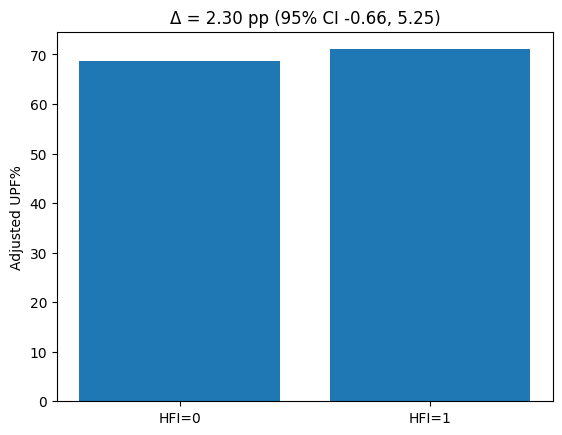

In [14]:
means = df_main.groupby("HFI_binary").apply(
    lambda g: np.average(g["weighted_upf_percent"], weights=g["sw_demo"])
)
plt.bar(["HFI=0", "HFI=1"], means)
plt.ylabel("Adjusted UPF%")
plt.title(f"Δ = {delta:.2f} pp (95% CI {ci[0]:.2f}, {ci[1]:.2f})")
plt.show()


# Core-B（HFI × Ethnicity3 交互）

分组计数：
 ethnicity3
White British    156
Pakistani         76
Mixed             33
Name: count, dtype: int64
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    66.1332      2.944     22.466      0.000      60.364      71.903
C(ethnicity3)[T.Pakistani]                   -1.3195      3.502     -0.377      0.706      -8.184       5.545
C(ethnicity3)[T.White British]                5.7143      3.138      1.821      0.069      -0.436      11.864
HFI_binary                                    8.2725      4.933      1.677      0.094      -1.396      17.941
HFI_binary:C(ethnicity3)[T.Pakistani]        -6.9849      5.687     -1.228      0.219     -18.132       4.162
HFI_binary:C(ethnicity3)[T.White British]    -7.5063      5.408     -1.388      0.165     -18.106       3.094
       Ethnic

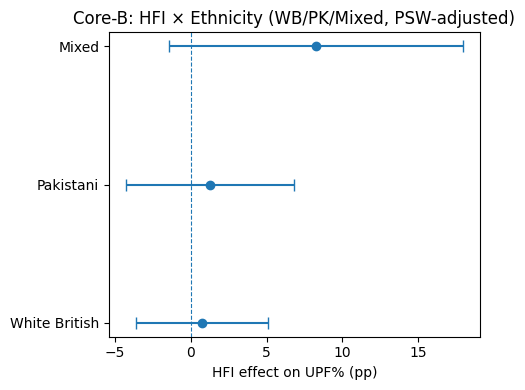

In [38]:
# 0) 统一把 ethn_participant==7 映射成 Mixed，再生成 3 组 ethnicity3
df3 = df_model.copy()
df3["ethnicity3"] = df3["ethn_participant"].map({
    1: "White British",
    3: "Pakistani",
    7: "Mixed"
}).fillna("Other")

# 1) 只保留三组；此处不要用你之前的 df_wbpk（那是 WB/PK-only）
keep = ["White British", "Pakistani", "Mixed"]
core_vars = ["HFI_binary","weighted_upf_percent","age_participant","gender_participant","ethnicity3"]
df3_core = df3.loc[df3["ethnicity3"].isin(keep), core_vars].dropna().copy()

print("分组计数：\n", df3_core["ethnicity3"].value_counts())
assert set(df3_core["ethnicity3"].unique()) == set(keep), "三组没有齐，检查映射或过滤！"

# 2) 在三组数据上估 PS（人口学）并计算稳定化权重
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf

X = pd.get_dummies(df3_core[["age_participant","gender_participant","ethnicity3"]], drop_first=True)
y = df3_core["HFI_binary"].astype(int)

ps = LogisticRegression(max_iter=1000).fit(X, y).predict_proba(X)[:,1]
p1 = y.mean()
df3_core["sw_demo"] = np.where(y==1, p1/ps, (1-p1)/(1-ps))

# 3) Core-B：交互模型（三组）
m_coreB3 = smf.wls("weighted_upf_percent ~ HFI_binary * C(ethnicity3)",
                   data=df3_core, weights=df3_core["sw_demo"]).fit(cov_type="HC3")
print(m_coreB3.summary().tables[1])

# 4) 提取每组 Δ（pp）+ 95%CI
rows = []
for g in keep:
    sub = df3_core[df3_core["ethnicity3"]==g]
    mm = smf.wls("weighted_upf_percent ~ HFI_binary", data=sub, weights=sub["sw_demo"]).fit(cov_type="HC3")
    ci = mm.conf_int().loc["HFI_binary"].tolist()
    rows.append([g, mm.params["HFI_binary"], ci[0], ci[1]])

out3 = pd.DataFrame(rows, columns=["Ethnicity","Δ (pp)","95% CI lower","95% CI upper"]).round(2)
print(out3)

# 5) 画三组分层点图
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,4))
ax.errorbar(out3["Δ (pp)"], out3["Ethnicity"],
            xerr=[out3["Δ (pp)"]-out3["95% CI lower"], out3["95% CI upper"]-out3["Δ (pp)"]],
            fmt='o', capsize=4)
ax.axvline(0, linestyle='--', lw=0.8)
ax.set_xlabel("HFI effect on UPF% (pp)")
ax.set_title("Core-B: HFI × Ethnicity (WB/PK/Mixed, PSW-adjusted)")
plt.tight_layout(); plt.show()


# Sens-SES 代码

In [21]:
# ==== Sens-SES：把收入、就业加入PS模型 ====

# 确认 income / employ 列名
cands_income = [c for c in df_model.columns if "income" in c.lower()]
cands_employ = [c for c in df_model.columns if "employ" in c.lower() or "employment" in c.lower()]

print("候选 income 列：", cands_income)
print("候选 employ 列：", cands_employ)

income_col = cands_income[0]
employ_col = cands_employ[0]

# 构建 Sens-SES 数据集（人口学 + SES）
ses_vars_all = ["age_participant", "gender_participant", "ethnicity3", income_col, employ_col,
                "HFI_binary", "weighted_upf_percent"]

df_ses = df_model[ses_vars_all].dropna().copy()
print("Sens-SES 样本量：", len(df_ses))

# 如果收入是连续型，做五分位
if np.issubdtype(df_ses[income_col].dtype, np.number):
    df_ses["income_q"] = pd.qcut(df_ses[income_col], q=5, duplicates="drop")
    income_use = "income_q"
else:
    income_use = income_col

# 倾向评分模型（人口学+SES）
X_ses = pd.get_dummies(
    df_ses[["age_participant", "gender_participant", "ethnicity3", income_use, employ_col]],
    drop_first=True
)
y_ses = df_ses["HFI_binary"]

ps_model_ses = LogisticRegression(max_iter=1000)
ps_model_ses.fit(X_ses, y_ses)
ps_ses = ps_model_ses.predict_proba(X_ses)[:, 1]

# 稳定化权重
p_treat_ses = y_ses.mean()
df_ses["sw_ses"] = np.where(y_ses == 1, p_treat_ses / ps_ses, (1 - p_treat_ses) / (1 - ps_ses))

# 加权模型
model_ses = smf.wls(
    "weighted_upf_percent ~ HFI_binary",
    data=df_ses,
    weights=df_ses["sw_ses"]
).fit(cov_type="HC3")

delta_ses = model_ses.params["HFI_binary"]
ci_ses = model_ses.conf_int().loc["HFI_binary"]

# 计算衰减
delta_coreA = model_psw.params["HFI_binary"]
attenuation = (delta_coreA - delta_ses) / delta_coreA * 100

print(f"[SES-adjusted PSW] Δ = {delta_ses:.2f} pp (95% CI {ci_ses[0]:.2f}, {ci_ses[1]:.2f})")
print(f"衰减幅度: {attenuation:.1f}%  (Core-A: {delta_coreA:.2f} pp → SES: {delta_ses:.2f} pp)")


候选 income 列： ['income']
候选 employ 列： ['employ']
Sens-SES 样本量： 303
[SES-adjusted PSW] Δ = 2.52 pp (95% CI -0.86, 5.89)
衰减幅度: -9.6%  (Core-A: 2.30 pp → SES: 2.52 pp)


# 把 Core-A / Core-B / Sens-SES 汇总成一个干净的 Table 2

In [23]:
# Core-A 主效应
delta_coreA = model_psw.params["HFI_binary"]
ci_coreA = model_psw.conf_int().loc["HFI_binary"]

# Core-B 族群分层（直接用之前 df_group）
# 为了保持顺序：WB → Pakistani → Other
eth_order = ["White British", "Pakistani", "Other"]
df_group_sorted = df_group.set_index("Ethnicity").loc[eth_order].reset_index()

# Sens-SES
delta_ses = model_ses.params["HFI_binary"]
ci_ses = model_ses.conf_int().loc["HFI_binary"]

# 拼接总表
table2 = pd.DataFrame([
    ["Core-A: Main effect (PSW, adj. demographics)", delta_coreA, ci_coreA[0], ci_coreA[1]],
    ["Core-B: White British", df_group_sorted.loc[df_group_sorted["Ethnicity"]=="White British", "Δ (pp)"].values[0],
     df_group_sorted.loc[df_group_sorted["Ethnicity"]=="White British", "95% CI lower"].values[0],
     df_group_sorted.loc[df_group_sorted["Ethnicity"]=="White British", "95% CI upper"].values[0]],
    ["Core-B: Pakistani", df_group_sorted.loc[df_group_sorted["Ethnicity"]=="Pakistani", "Δ (pp)"].values[0],
     df_group_sorted.loc[df_group_sorted["Ethnicity"]=="Pakistani", "95% CI lower"].values[0],
     df_group_sorted.loc[df_group_sorted["Ethnicity"]=="Pakistani", "95% CI upper"].values[0]],
    ["Core-B: Other", df_group_sorted.loc[df_group_sorted["Ethnicity"]=="Other", "Δ (pp)"].values[0],
     df_group_sorted.loc[df_group_sorted["Ethnicity"]=="Other", "95% CI lower"].values[0],
     df_group_sorted.loc[df_group_sorted["Ethnicity"]=="Other", "95% CI upper"].values[0]],
    ["Sens-SES: PSW + SES (income, employment)", delta_ses, ci_ses[0], ci_ses[1]]
], columns=["Model", "Δ (pp)", "95% CI lower", "95% CI upper"])

# 美化小数位
table2[["Δ (pp)", "95% CI lower", "95% CI upper"]] = table2[["Δ (pp)", "95% CI lower", "95% CI upper"]].round(2)

# 创建一个 Δ (pp) [95% CI] 列
table2_pretty = table2.copy()
table2_pretty["Δ (pp) [95% CI]"] = table2_pretty.apply(
    lambda row: f"{row['Δ (pp)']:.2f} ({row['95% CI lower']:.2f}, {row['95% CI upper']:.2f})",
    axis=1
)

# 只保留 Model 和合并列
table2_pretty = table2_pretty[["Model", "Δ (pp) [95% CI]"]]

# 重命名列头
table2_pretty.columns = ["Model", "Effect size (pp) [95% CI]"]

# 打印
print(table2_pretty.to_string(index=False))


                                       Model Effect size (pp) [95% CI]
Core-A: Main effect (PSW, adj. demographics)        2.30 (-0.66, 5.25)
                       Core-B: White British        0.76 (-3.60, 5.12)
                           Core-B: Pakistani        1.27 (-4.27, 6.81)
                               Core-B: Other        6.54 (1.09, 11.98)
    Sens-SES: PSW + SES (income, employment)        2.52 (-0.86, 5.89)


# 可视化配图

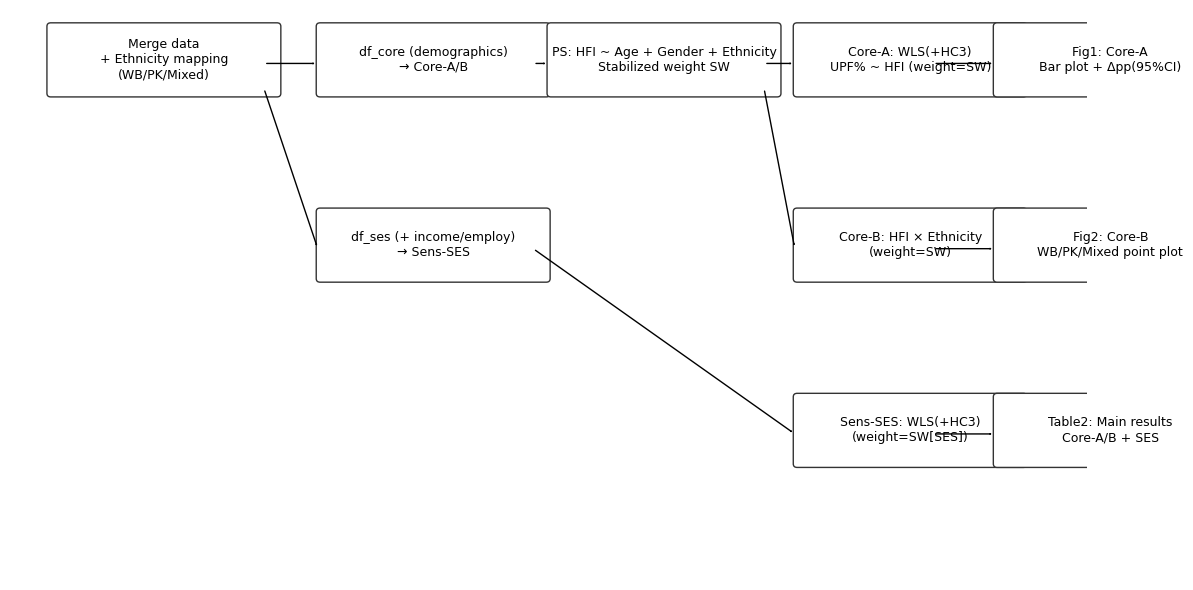

In [40]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

def box(ax, xy, text, fc='#FFFFFF', ec='#333333'):
    x, y = xy
    w, h = 3.0, 1.0
    rect = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.02,rounding_size=0.05",
                          ec=ec, fc=fc, lw=1)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=9)

def arrow(ax, p, q):
    ax.add_patch(FancyArrowPatch(p, q, arrowstyle='->', lw=1))

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')
ax.set_xlim(0, 14)
ax.set_ylim(0, 8)

# y positions
y3, y2, y1 = 6.8, 4.2, 1.6

# Data preparation
box(ax, (0.5, y3), 'Merge data\n+ Ethnicity mapping\n(WB/PK/Mixed)')
box(ax, (4.0, y3), 'df_core (demographics)\n→ Core-A/B')
box(ax, (4.0, y2), 'df_ses (+ income/employ)\n→ Sens-SES')
arrow(ax, (3.3, y3 + 0.45), (4.0, y3 + 0.45))
arrow(ax, (3.3, y3 + 0.10), (4.0, y2 + 0.45))

# PSW (demographics)
box(ax, (7.0, y3), 'PS: HFI ~ Age + Gender + Ethnicity\nStabilized weight SW')
arrow(ax, (6.8, y3 + 0.45), (7.0, y3 + 0.45))

# Models
box(ax, (10.2, y3), 'Core-A: WLS(+HC3)\nUPF% ~ HFI (weight=SW)')
box(ax, (10.2, y2), 'Core-B: HFI × Ethnicity\n(weight=SW)')
box(ax, (10.2, y1), 'Sens-SES: WLS(+HC3)\n(weight=SW[SES])')
arrow(ax, (9.8, y3 + 0.45), (10.2, y3 + 0.45))
arrow(ax, (9.8, y3 + 0.10), (10.2, y2 + 0.45))
arrow(ax, (6.8, y2 + 0.45), (10.2, y1 + 0.45))

# Outputs
box(ax, (12.8, y3), 'Fig1: Core-A\nBar plot + Δpp(95%CI)')
box(ax, (12.8, y2), 'Fig2: Core-B\nWB/PK/Mixed point plot')
box(ax, (12.8, y1), 'Table2: Main results\nCore-A/B + SES')
arrow(ax, (12.0, y3 + 0.45), (12.8, y3 + 0.45))
arrow(ax, (12.0, y2 + 0.45), (12.8, y2 + 0.45))
arrow(ax, (12.0, y1 + 0.45), (12.8, y1 + 0.45))

plt.tight_layout()
plt.show()
